# EDA

In [117]:
import os
mao_sentences = []
for root, dirs, files in os.walk("../mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().replace('?','.').replace('!','.').replace('\n','.')
                sentences = sentences.split(".")   #. denotes end of sentence
            mao_sentences.extend(sentences)
            
print(len(mao_sentences))
print(mao_sentences[0])

../mao/REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
../mao/WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
../mao/ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
../mao/ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
../mao/A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
../mao/BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
1702
THE IMPORTANCE OF THE PEASANT PROBLEM


In [118]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

,Sentence
0,THE IMPORTANCE OF THE PEASANT PROBLEM
1,During my recent visit to Hunan [1] I made a f...
2,In the thirty-two days from January 4 to Febr...
3,Many of the hows and whys of the peasant move...
4,I saw and heard of many strange things of whi...


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

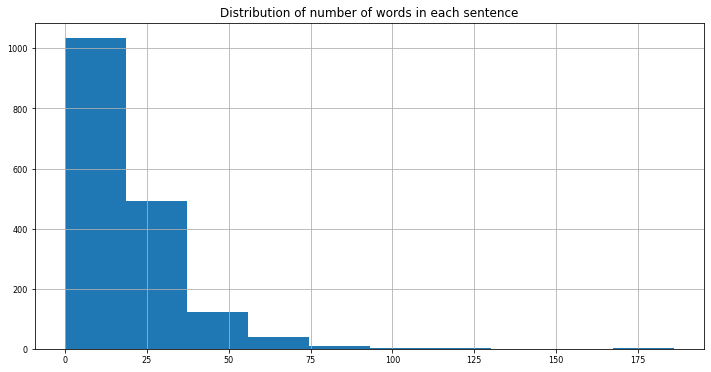

In [119]:
mao_df['NumWords'] = mao_df['Sentence'].apply(lambda x: len(x.split()))
mao_df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

Let's do some cleaning operations like turning all words to lowercase, remove punctuation and non-ASCII characters which are irrelevant for modeling topics.

In [120]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df.head()
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

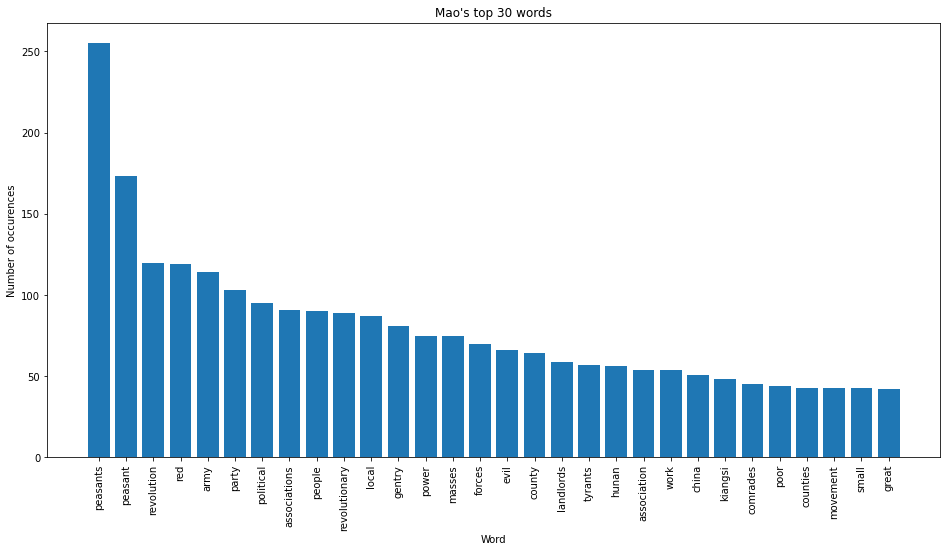

In [121]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(mao_df['Sentence2'], 30):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 30 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [159]:
mao_df.head()

,Sentence,NumWords,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,saw and heard many strange things which had hi...


Remove short sentence

In [131]:
mao_df = mao_df[mao_df.NumWords>0]
short_sentence = mao_df[mao_df.NumWords<5]
short_sentence

,Sentence,NumWords,Sentence2
14,There are three alternatives,4,there are three alternatives
21,GET ORGANIZED,2,get organized
53,"""Here's ten yuan",3,here ten yuan
57,"""Ugh",1,ugh
59,""" the peasants reply",4,the peasants reply
...,...,...,...
1655,Not in the least,4,not the least
1659,"No, nothing",2,nothing
1660,His bastions of iron,4,his bastions iron
1661,They all crumbled,3,they all crumbled


In [133]:
mao_df = mao_df[mao_df.NumWords>=5]
mao_df = mao_df.reset_index(drop=True)
mao_df

,Sentence,NumWords,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM,6,the importance the peasant problem
1,During my recent visit to Hunan [1] I made a f...,25,during recent visit hunan made first hand inve...
2,In the thirty-two days from January 4 to Febr...,48,the thirty two days from january february call...
3,Many of the hows and whys of the peasant move...,24,many the hows and whys the peasant movement we...
4,I saw and heard of many strange things of whi...,15,saw and heard many strange things which had hi...
...,...,...,...
1167,All revolutionary cadres have a tremendous re...,7,all revolutionary cadres have tremendous respo...
1168,After this congress we must adopt effective m...,30,after this congress must adopt effective measu...
1169,We must create thousands of townships like Ch...,14,must create thousands townships like changkang...
1170,They will be our strongholds,5,they will our strongholds


# Sentence Embedding

In [66]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('stsb-roberta-large')

In [134]:
sentence_embeddings = model.encode(mao_df.Sentence2)
sentence_embeddings.shape

(1172, 1024)

# Kmeans

Try to find the best k, let us use `Silhouette Coefficient`

Silhouette Coefficient    
https://en.wikipedia.org/wiki/Silhouette_(clustering)   

-1<=Si<=1   
The clusting performance is better when the Silhouette Coefficient is close to 1

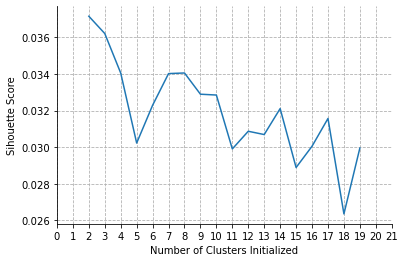

In [135]:
from sklearn import metrics
from sklearn.cluster import KMeans

scores = []
for k in range(2,20):
    labels = KMeans(n_clusters=k).fit(sentence_embeddings).labels_
    score = metrics.silhouette_score(sentence_embeddings, labels)
    scores.append(score)

plt.plot(list(range(2,20)),scores)
plt.xticks(range(0,22,1)) 
plt.grid(linestyle='--')
plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Sihouette Score")
sns.despine()

## 7 cluster Kmeans

In [136]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=7, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(sentence_embeddings)
df = pd.DataFrame({'mao': mao_df.Sentence, 'topic_cluster': y_km })

In [137]:
df.head()

,mao,topic_cluster
0,THE IMPORTANCE OF THE PEASANT PROBLEM,4
1,During my recent visit to Hunan [1] I made a f...,1
2,In the thirty-two days from January 4 to Febr...,4
3,Many of the hows and whys of the peasant move...,1
4,I saw and heard of many strange things of whi...,0


In [138]:
df.loc[df['topic_cluster'] == 0].head()

,mao,topic_cluster
4,I saw and heard of many strange things of whi...,0
15,"To trail behind them, gesticulating and criti...",0
29,DOWN WITH THE LOCAL TYRANTS AND EVIL GENTRY,0
31,The main targets of attack by the peasants are...,0
39,Those who are outside the associations can on...,0


In [139]:
df.loc[df['topic_cluster'] == 1].head()

,mao,topic_cluster
1,During my recent visit to Hunan [1] I made a f...,1
3,Many of the hows and whys of the peasant move...,1
20,"In this period, January to June was a time of...",1
41,In the face of the peasant associations' powe...,1
47,"In the Ching Dynasty, the household census com...",1


In [140]:
df.loc[df['topic_cluster'] == 2].head()

,mao,topic_cluster
5,I believe the same is true of many other plac...,2
11,They will smash all the trammels that bind th...,2
14,To march at their head and lead them,2
16,Or to stand in their way and oppose them,2
17,"Every Chinese is free to choose, but events w...",2


In [141]:
df.loc[df['topic_cluster'] == 3].head()

,mao,topic_cluster
6,All talk directed against the peasant movemen...,3
7,All the wrong measures taken by the revolutio...,3
12,"They will sweep all the imperialists, warlord...",3
33,"As a result, the privileges which the feudal ...",3
43,Who wants your filthy money,3


In [142]:
df.loc[df['topic_cluster'] == 4].head()

,mao,topic_cluster
0,THE IMPORTANCE OF THE PEASANT PROBLEM,4
2,In the thirty-two days from January 4 to Febr...,4
9,For the present upsurge of the peasant moveme...,4
18,The development of the peasant movement in Hun...,4
22,"Since its members served as guides, scouts an...",4


In [143]:
df.loc[df['topic_cluster'] == 5].head()

,mao,topic_cluster
13,Every revolutionary party and every revolutio...,5
21,"During this period, the membership of the pea...",5
40,"The local tyrants, evil gentry and lawless la...",5
48,In some places the peasants now use this meth...,5
50,"Afraid of being entered in the other register,...",5


In [144]:
df.loc[df['topic_cluster'] == 6].head()

,mao,topic_cluster
8,Only thus can the future of the revolution be...,6
10,"In a very short time, in China's central, sou...",6
32,In force and momentum the attack is tempestuo...,6
67,"Sun Yat-sen wanted, but failed, to accomplish...",6
78,The Revolution of 1911 [3] did not bring abou...,6


In [145]:
centers = km.cluster_centers_
centers

array([[-0.30953214,  0.6305128 ,  0.32809758, ...,  0.27771795,
        -0.7601069 ,  0.6205398 ],
       [ 0.10599337,  0.34588677, -0.1222178 , ...,  0.54810643,
        -1.3297417 ,  0.29887426],
       [-0.12595537,  0.14595088, -0.06924995, ...,  0.27791902,
        -0.7823045 ,  0.54073364],
       ...,
       [-0.06784983,  0.34416237, -0.10358737, ...,  0.96032333,
        -0.90393364,  0.54917824],
       [-0.10502759,  0.02465358, -0.22885872, ...,  0.3169937 ,
        -0.14310676,  0.47161007],
       [ 0.20314845,  0.7646339 ,  0.06447814, ...,  0.8604767 ,
        -0.79031605,  0.37310952]], dtype=float32)

Select a sentence which is cloest to each group center

In [146]:
def select_center_sentence(group_id):
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = sentence_embeddings[df['topic_cluster'] == group_id]
    print('there are %d sentences in group %d'%(len(group_sentence_embeddings),group_id))
    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    df_group = df.loc[df['topic_cluster'] == group_id]
    df_group = df_group.reset_index(drop=True)
    return df_group.mao[min_index]

In [147]:
group0_belief = select_center_sentence(group_id = 0)
group0_belief

there are 179 sentences in group 0


'" This opinion comes to the same thing as what the right-wingers are saying; according to both it is all right to have a peasant movement (the movement is already in being and no one dare say otherwise), but they say that the people running it are no good and they particularly hate those in charge of the associations at the lower levels, calling them "riffraff"'

In [148]:
group1_belief = select_center_sentence(group_id = 1)
group1_belief

there are 159 sentences in group 1


' Again, when we captured Yunghsin for the third time, we once more divided our forces by dispatching the 28th Regiment to the border of Anfu County, the 29th to Lienhua, and the 31st to the border of Kian County'

In [149]:
group2_belief = select_center_sentence(group_id = 2)
group2_belief

there are 196 sentences in group 2


' It should be done on the following lines:'

In [150]:
group3_belief = select_center_sentence(group_id = 3)
group3_belief

there are 146 sentences in group 3


' Because of the growth in government taxation, the rise in rent and interest demanded by the landlords and the daily spread of the disasters of war, there are famine and banditry everywhere and the peasant masses and the urban poor can hardly keep alive'

In [151]:
group4_belief = select_center_sentence(group_id = 4)
group4_belief

there are 180 sentences in group 4


'ALL POWER TO THE PEASANT ASSOCIATIONS'

In [152]:
group5_belief = select_center_sentence(group_id = 5)
group5_belief

there are 135 sentences in group 5


' It was necessary to forbid malicious criticism of the peasant associations'

In [153]:
group6_belief = select_center_sentence(group_id = 6)
group6_belief

there are 177 sentences in group 6


' The prolonged splits and wars within the White regime provide a condition for the emergence and persistence of one or more small Red areas under the leadership of the Communist Party amidst the encirclement of the White regime'